Bibliotecas usadas no projeto

In [1]:
from random import randint
import networkx as nx
import matplotlib.pyplot as plt
import pylab
from IPython.display import clear_output
from time import sleep
import gym
env = gym.make('Taxi-v3').env # Taxi-v3 nos fornece a estrutura inicial do mapa, incluindo suas chaves para as posições

#### Representação do mapa e do trajeto que o táxi terá que fazer, indo do ponto 'rosa' até o ponto 'azul'

In [2]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### Definindo o grafo do mapa com os respectivos pesos entre os nós conectados

In [10]:
grafo_mapa = {}
grafo_mapa[0] = {20: randint(1, 100), 100: randint(1, 100)}
grafo_mapa[20] = {0: randint(1, 100), 120: randint(1, 100)}
grafo_mapa[40] = {60: randint(1, 100), 140: randint(1, 100)}
grafo_mapa[60] = {40: randint(1, 100), 80: randint(1, 100), 160: randint(1, 100)}
grafo_mapa[80] = {60: randint(1, 100), 180: randint(1, 100)}
grafo_mapa[100] = {0: randint(1, 100), 120: randint(1, 100), 200: randint(1, 100)}
grafo_mapa[120] = {20: randint(1, 100), 100: randint(1, 100), 220: randint(1, 100)}
grafo_mapa[140] = {40: randint(1, 100), 160: randint(1, 100), 240: randint(1, 100)}
grafo_mapa[160] = {60: randint(1, 100), 140: randint(1, 100), 180: randint(1, 100), 260: randint(1, 100)}
grafo_mapa[180] = {80: randint(1, 100), 160: randint(1, 100), 280: randint(1, 100)}
grafo_mapa[200] = {100: randint(1, 100), 220: randint(1, 100), 300: randint(1, 100)}
grafo_mapa[220] = {200: randint(1, 100), 120: randint(1, 100), 240: randint(1, 100), 320: randint(1, 100)}
grafo_mapa[240] = {220: randint(1, 100), 140: randint(1, 100), 260: randint(1, 100), 340: randint(1, 100)}
grafo_mapa[260] = {240: randint(1, 100), 160: randint(1, 100), 280: randint(1, 100), 360: randint(1, 100)}
grafo_mapa[280] = {260: randint(1, 100), 180: randint(1, 100), 380: randint(1, 100)}
grafo_mapa[300] = {200: randint(1, 100), 400: randint(1, 100)}
grafo_mapa[320] = {220: randint(1, 100), 340: randint(1, 100), 420: randint(1, 100)}
grafo_mapa[340] = {240: randint(1, 100), 320: randint(1, 100), 440: randint(1, 100)}
grafo_mapa[360] = {260: randint(1, 100), 380: randint(1, 100), 460: randint(1, 100)}
grafo_mapa[380] = {280: randint(1, 100), 360: randint(1, 100), 480: randint(1, 100)}
grafo_mapa[400] = {300: randint(1, 100)}
grafo_mapa[420] = {320: randint(1, 100), 440: randint(1, 100)}
grafo_mapa[440] = {340: randint(1, 100), 420: randint(1, 100)}
grafo_mapa[460] = {360: randint(1, 100), 480: randint(1, 100)}
grafo_mapa[480] = {380: randint(1, 100), 460: randint(1, 100)}

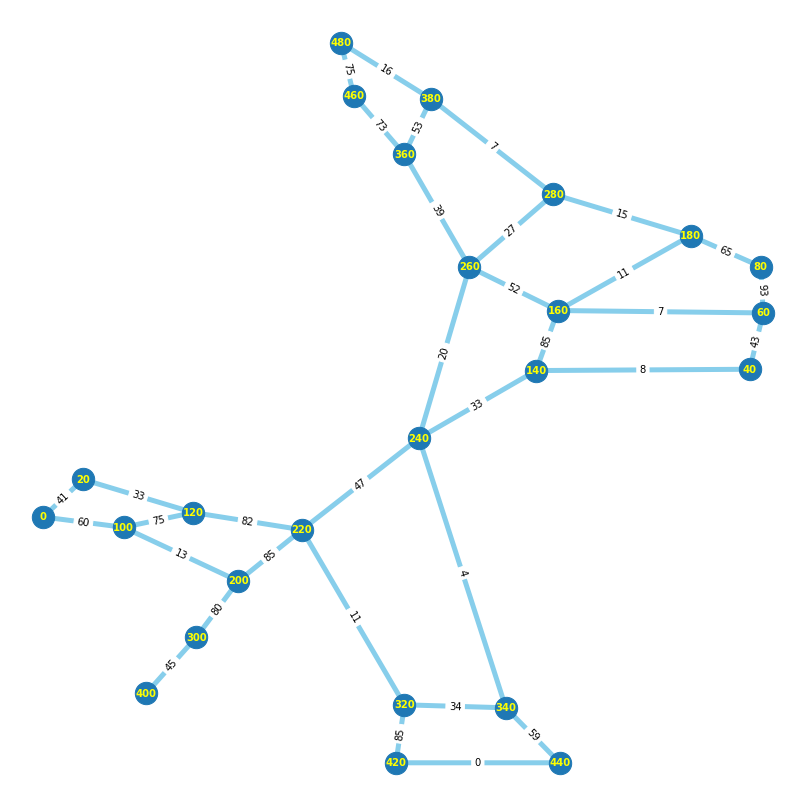

In [9]:
G = nx.Graph()
plt.figure(1,figsize=(11,11)) 

for k in grafo_mapa:
    for v in grafo_mapa[k]:
        G.add_edge(k, v, weight=grafo_mapa[k][v])

pos=nx.spring_layout(G)
pylab.figure(1)
nx.draw(G,pos, with_labels=True, node_size=500, font_size=10, width=5, font_color="yellow", font_weight="bold", edge_color="skyblue", style="solid")
edge_labels=dict([((u,v,),d['weight'])
for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
pylab.show()
# O grafo gerado pode ser apresentado de forma um pouco confusa, mas não incorreta,
# para uma visualização melhor, basta executar essa célula outras vezes até gerar um grafo mais claro

#### Algoritmo de Dijkstra

In [3]:
def dijkstra(grafo, origem, fim, taxiTrajeto):
    """Função responsável por retornar a menor distância de um nó de origem
    até um nó de destino e o caminho até ele"""

    controle = { }
    distanciaAtual = { }
    noAtual = { }
    naoVisitados = []
    atual = origem
    noAtual[atual] = 0

    
    for vertice in grafo.keys():
        naoVisitados.append(vertice) # Inclui os vértices nos não visitados    
        distanciaAtual[vertice] = float('inf') # Inicia os vértices como infinito

    distanciaAtual[atual] = [0,origem] 

    naoVisitados.remove(atual)

    while naoVisitados:
        for vizinho, peso in grafo[atual].items():
            pesoCalc = peso + noAtual[atual]
            if distanciaAtual[vizinho] == float("inf") or distanciaAtual[vizinho][0] > pesoCalc:
                distanciaAtual[vizinho] = [pesoCalc,atual]
                controle[vizinho] = pesoCalc
                 
        if controle == {} : break    
        minVizinho = min(controle.items(), key=lambda x: x[1]) # Seleciona o menor vizinho
        atual = minVizinho[0]
        noAtual[atual] = minVizinho[1]
        naoVisitados.remove(atual)
        del controle[atual]

    taxiTrajeto.extend([distanciaAtual[fim][0], fim])
    returnTrajeto(distanciaAtual, origem, fim, taxiTrajeto)         
    

def returnTrajeto(distancias, inicio, fim, taxiTrajeto):
        if  fim != inicio:
            taxiTrajeto.append(distancias[fim][1])
            returnTrajeto(distancias, inicio, distancias[fim][1], taxiTrajeto)
        else:
            return inicio

### Renderizando o mapa e fazendo o táxi levar o passageiro até o destino

In [12]:
def print_frames(frames, distancia, segundos=0.5):
    """Função responsável por printar cada estado do mapa, fazendo com que o taxi
    se movimente até o passageiro e depois até o destino"""

    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f'Passos dados (Timesteps): {i+1}')
        print(f"Estado: {frame['estado']}")
        sleep(segundos)
    print(f'Custo do caminho: {distancia}')


def trajeto_taxi(Y_taxi, X_taxi, id_destino, id_passageiro, segundos=0.5):
    """Função responsável por encontrar o caminho que o táxi tem que fazer para ir até
    o passageiro e depois até o destino"""

    # Estado do mapa que é configurado pelo index do passageiro e do destino, quando o taxi está na posição (0,0)
    posicao_pass_dest = env.encode( 0, 0, id_destino, id_passageiro) # linha do taxi | coluna do taxi | index do destino | index do passageiro

    # Remapeando o grafo que representa o mapa real que o táxi tem que percorrer
    grafo_taxi = {k + posicao_pass_dest: {k + posicao_pass_dest: v for k,v in grafo_mapa[k].items()} for k,v in grafo_mapa.items()}

    # Gerando o estado inicial do mapa
    posicao_taxi = env.encode(Y_taxi, X_taxi, id_destino, id_passageiro)

    # Possíveis estados do mapa onde está o passageiro e o destino
    coor = [0, 80, 400, 460]

    # Estado do passageiro e do destino, considerando o configuração real do grafo, que representa o mapa
    coor_passageiro = coor[id_passageiro] + posicao_pass_dest
    coor_destino = coor[id_destino] + posicao_pass_dest

    trajeto = []
    # Utilizando o algoritmo de dijkstra para encontrar o caminho mais rápido entre a posição inicial do táxi e o passageiro
    dijkstra(grafo_taxi, posicao_taxi, coor_passageiro, trajeto)
    distancia = trajeto.pop(0)
    trajeto_passageiro = trajeto[::-1].copy()


    trajeto = []
    # Utilizando o algoritmo de dijkstra para encontrar o caminho mais rápido entre o passageiro e o destino
    dijkstra(grafo_taxi, coor_passageiro, coor_destino, trajeto)
    distancia += trajeto.pop(0)
    trajeto_destino = trajeto[::-1].copy()

    frames = []

    for estado in trajeto_passageiro:

        # Variável responsável por guardar no ambiente env o estado atual do mapa
        env.s = estado

        acao = 0

        frames.append({
                'frame': env.render(mode='ansi'), # Renderiza o estado do mapa no formato ansi
                'estado': estado,
                'ação': acao,
            })

    for estado in trajeto_destino:  
        env.s = estado

        acao = 4
        if estado == coor_destino:
            acao = 5

        frames.append({
                'frame': env.render(mode='ansi'), 
                'estado': estado,
                'ação': acao,
            })

    # Representação do ato do táxi pegar o passageiro e levar até o destino
    for i, frame in enumerate(frames):
        if frame['ação'] == 4 or frame['ação'] == 5:
            frame['frame'] = frame['frame'].replace('35', '0').replace('43', '41')
    frame_fim = frames[-1].copy()
    frame_fim['frame'] = frame_fim['frame'].replace('41', '43')
    frames.append(frame_fim)

    print_frames(frames, distancia, segundos)

### Aleatorização das variáveis iniciais

In [13]:
xTaxi = randint(0, 4) # Gerando aleatoriamente a posição X do táxi
yTaxi = randint(0, 4) # Gerando aleatoriamente a posição y do táxi

idDestino = randint(0, 3) # Gerando aleatoriamente a posiçao destino

# Gerando aleatoriamente a posição do passageiro, certificando que não seja a mesma do destino
idsDiferentes = False
while not idsDiferentes:
    idPassageiro = randint(0, 3)
    if idPassageiro != idDestino:
        idsDiferentes = True

In [14]:
print(f'Posição inicial do táxi: {xTaxi, yTaxi}')
print(f'ID destino: {idDestino} (Azul)')
print(f'ID passageiro: {idPassageiro} (Rosa)')

Posição inicial do táxi: (3, 3)
ID destino: 0 (Azul)
ID passageiro: 1 (Rosa)


In [15]:
trajeto_taxi(yTaxi, xTaxi, idDestino, idPassageiro, 0.5) # Executa o programa

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Passos dados (Timesteps): 15
Estado: 1
Custo do caminho: 429
